# Classification non-supervisée de profils atypiques sur Twitter

## Chargement des données et prétraitement

In [66]:
# pip install pandas numpy matplotlib seaborn scikit-learn

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [68]:
data_file_path = '../dataset/cleaned_data_all.csv'

df = pd.read_csv(data_file_path, encoding='utf-8-sig')

In [69]:
print(df.head())

      user_id  followers_count  friends_count  statuses_count  retweet_count  \
0    39084553              556            826           32153              0   
1  4872447178             2805           3189            5162              0   
2    35628099               48            407             487              0   
3   351196385             4777            787           16515              0   
4  1874916350              114            380            1057              0   

   favorite_count  mention_count  url_count  text_length  \
0               0              1          0          140   
1               0              3          1          540   
2               0              2          0          140   
3               0              1          6          637   
4               0              1          0          139   

   follower_friend_ratio  active_hours  tweets_per_day  aggressiveness  \
0                  0.673      0.000000        0.000000        0.000000   
1         

In [70]:
# 将缺失值填充为0
df["follower_friend_ratio"] = df["follower_friend_ratio"].fillna(0)

In [71]:
# 去掉全部为0的无用特征
features = [
    'statuses_count', 'mention_count', 'url_count', 'text_length',
    'follower_friend_ratio', 'active_hours', 'tweets_per_day',
    'aggressiveness', 'visibility'
]

# 保证 features 中字段都在 df_clean 里
X = df[features]

# 检查各列的唯一值数量（如果有其他几乎恒定的列也可以考虑删）
print(X.nunique())


statuses_count           138334
mention_count               370
url_count                   292
text_length                9018
follower_friend_ratio     48612
active_hours             237312
tweets_per_day           374419
aggressiveness           401896
visibility                 8936
dtype: int64


d:\anaconda3\envs\open-machine-learning-jupyter-book\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


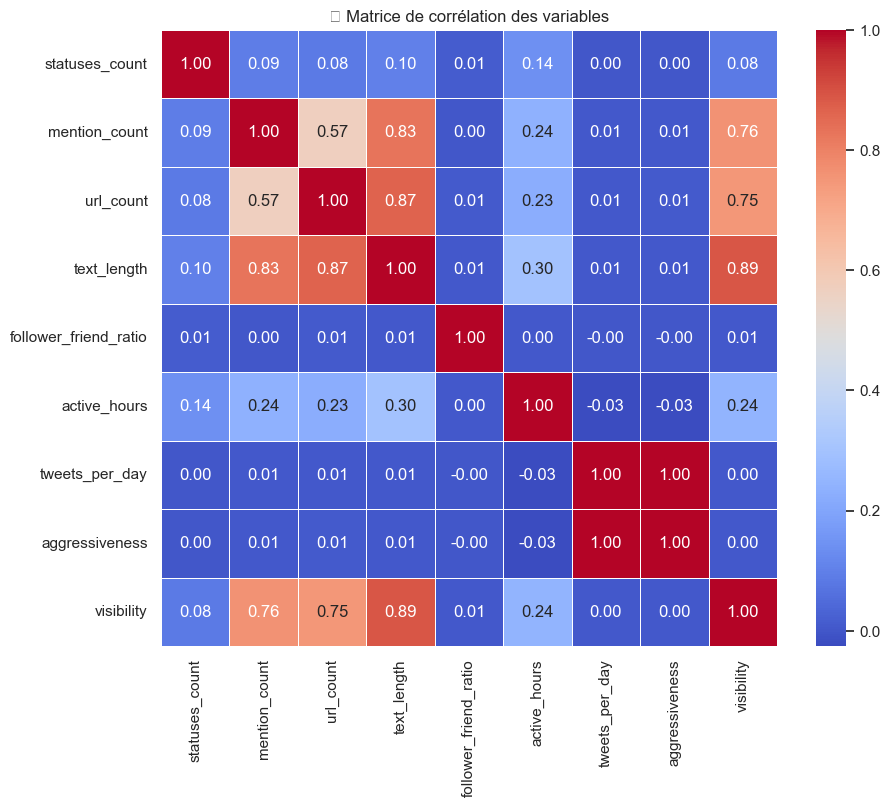

In [72]:
# 热力图查看变量间相关性（用于发现冗余或线性关系）
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("📊 Matrice de corrélation des variables")
plt.show()


💡 强相关性：
text_length 与 url_count、mention_count、visibility 的相关性都较强（>0.75）；

mention_count 和 visibility 的相关性达到 0.76；

url_count 和 text_length：0.87；

text_length 和 visibility：0.89。

👉 结论：这几个特征可能含有冗余信息（表示用户的“信息密度”特征），适合通过 PCA 来降维整合。

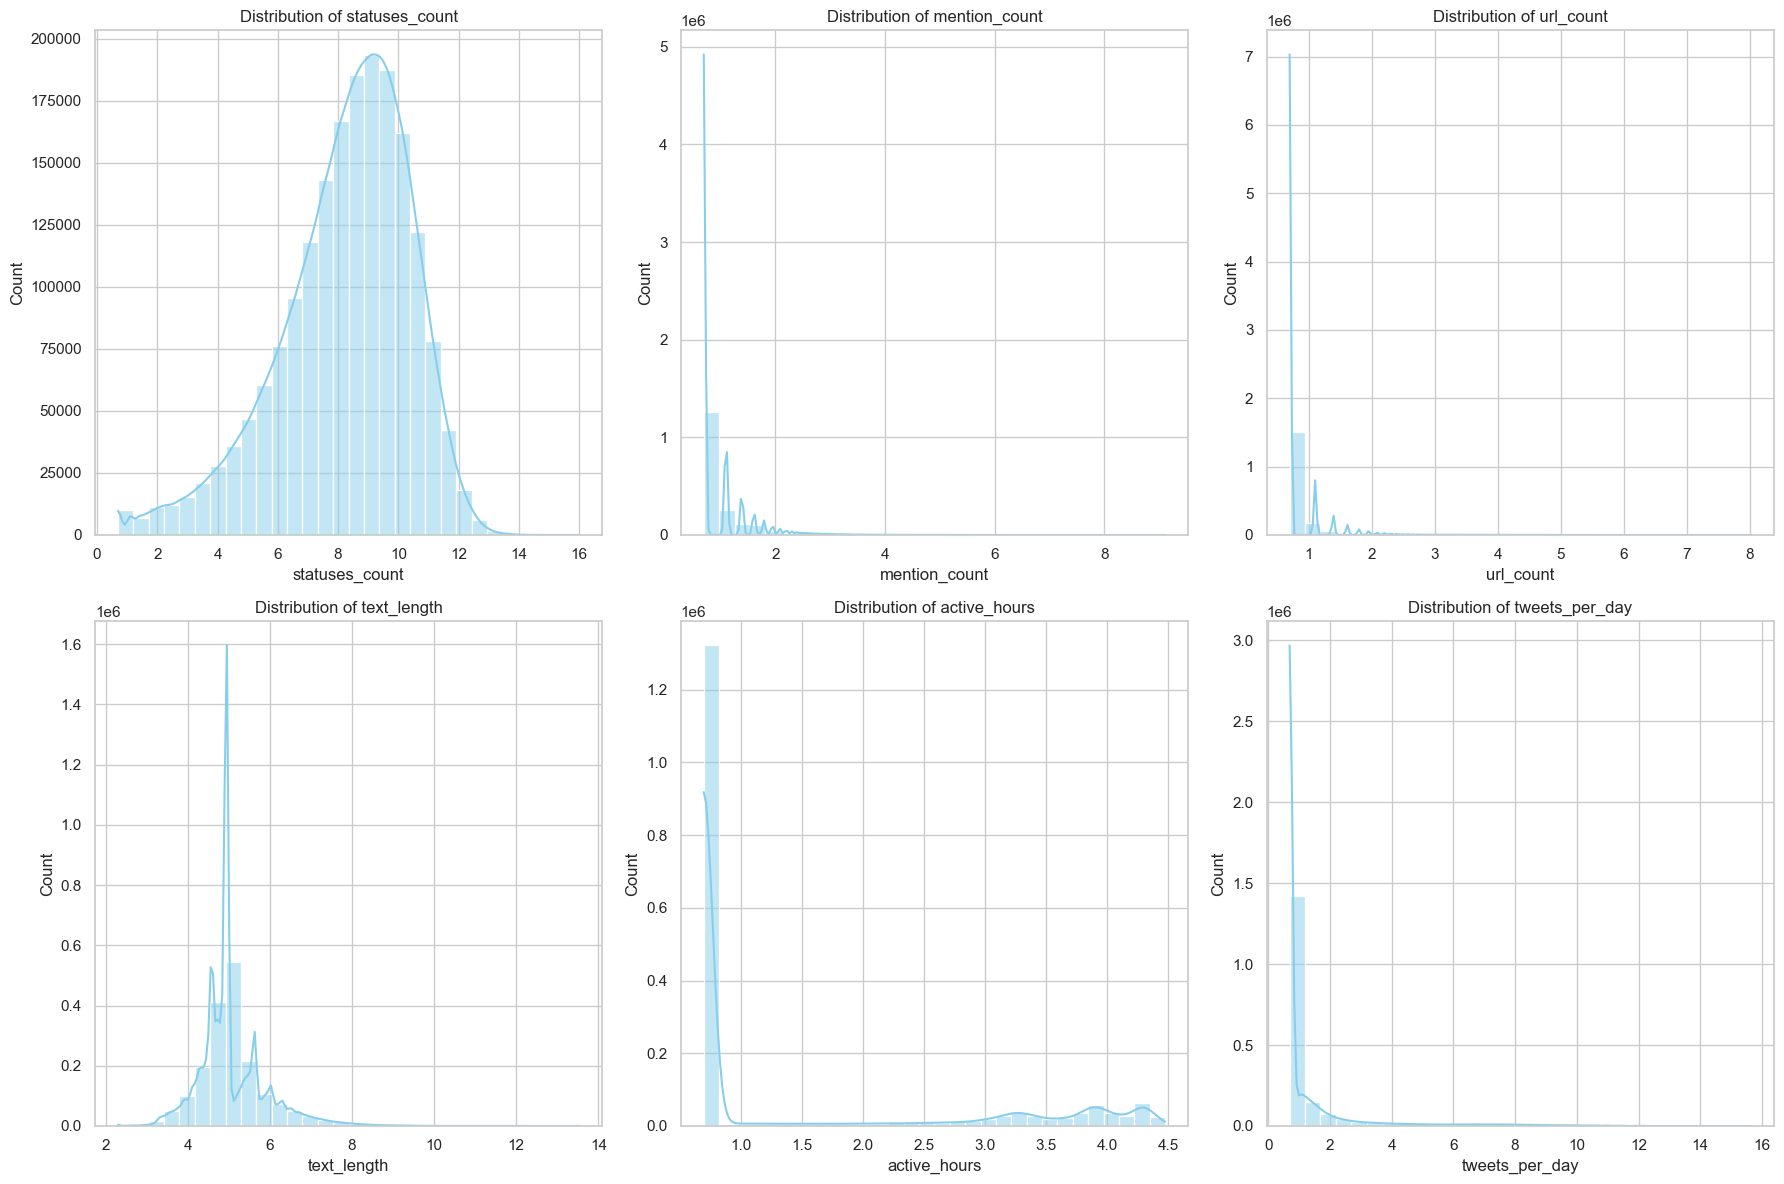

In [73]:
# 排除不需要绘制的特征
features_to_plot = [
    'statuses_count', 'mention_count', 'url_count', 'text_length',
    'active_hours', 'tweets_per_day'
]  # 排除了 follower_friend_ratio, aggressiveness, visibility

plt.figure(figsize=(18, 12))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1)  # 2行3列布局
    # 对数据进行对数变换(加1避免对0取对数)
    transformed_data = np.log1p(X[col].clip(lower=1))
    sns.histplot(transformed_data, kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [74]:
print(pd.DataFrame(X).isnull().sum())


statuses_count           0
mention_count            0
url_count                0
text_length              0
follower_friend_ratio    0
active_hours             0
tweets_per_day           0
aggressiveness           0
visibility               0
dtype: int64


In [75]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [80]:
X_scaled.shape

(1843439, 9)

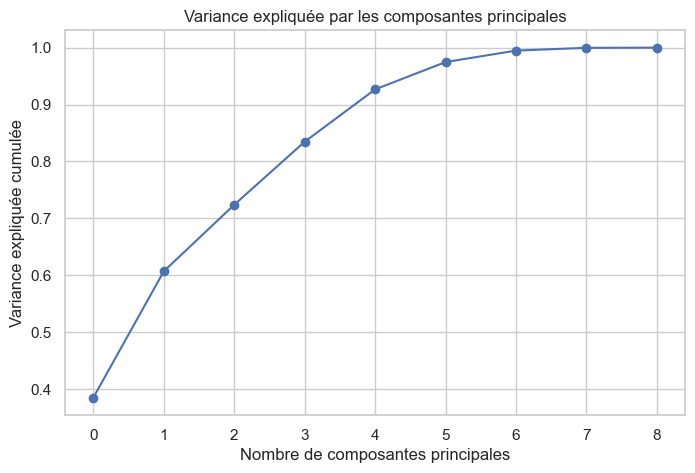

In [76]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 绘制累计解释方差图，确定主成分数量
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.title('Variance expliquée par les composantes principales')
plt.show()


前4个主成分可以解释大约93%的方差，已经非常充分了，

5个及以上成分的增益很小（已经接近100%），所以一般选择4个主成分比较合理，既保留了大部分信息，又避免维度过高。

In [82]:
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 选择主成分数量
n_components = 4

# 用4个主成分训练PCA
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# 从降维后的数据中随机抽样5000条，加快计算
X_sample = resample(X_pca_reduced, n_samples=5000, random_state=42)

silhouette_scores = []
K_range = range(2, 11)  # 从2到10个聚类试试

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette_score={score:.4f}")


k=2, silhouette_score=0.9949
k=3, silhouette_score=0.9474
k=4, silhouette_score=0.6910
k=5, silhouette_score=0.6917
k=6, silhouette_score=0.6788
k=7, silhouette_score=0.6537
k=8, silhouette_score=0.6635
k=9, silhouette_score=0.6612
k=10, silhouette_score=0.5852


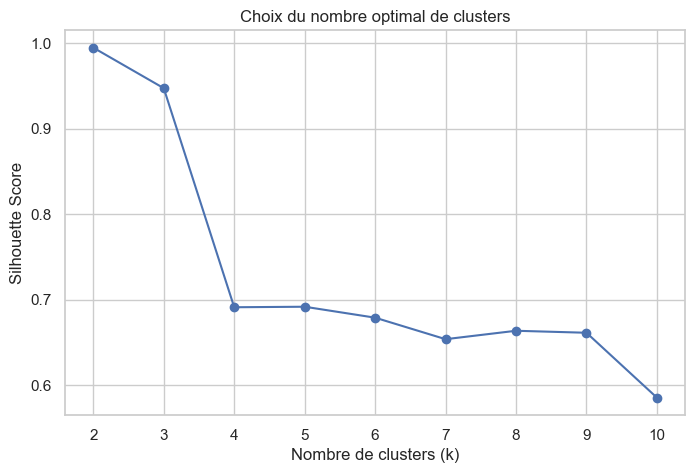

Meilleur nombre de clusters selon silhouette score: 2


In [84]:
# 绘制轮廓系数折线图，帮助选k
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Choix du nombre optimal de clusters')
plt.grid(True)
plt.show()

# 选轮廓系数最高的k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Meilleur nombre de clusters selon silhouette score: {optimal_k}")




cluster
0    1843438
1          1
Name: count, dtype: int64


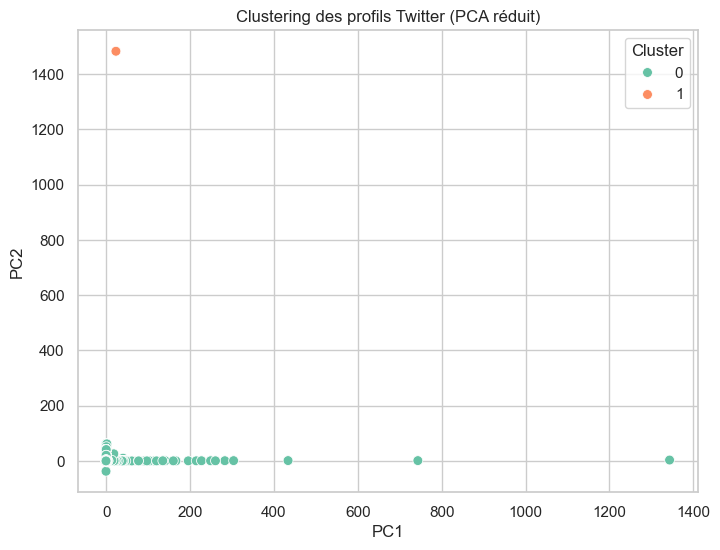

In [85]:
# 用最佳k做最终聚类
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_pca_reduced)

# 把聚类标签加入原数据
df['cluster'] = cluster_labels

# 查看每个类别样本数量
print(df['cluster'].value_counts())

# 用前两个主成分做聚类散点图展示
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_reduced[:,0], y=X_pca_reduced[:,1], hue=cluster_labels, palette='Set2', s=50)
plt.title('Clustering des profils Twitter (PCA réduit)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()